# Rainfall Prediction with Data Mining
## 1. Background
ADD PROJECT BACKGROUND

    
## 2. Methodology
- Define the problem statement
- Identify a viable data source
- Format the selected dataset 
- Understand the patterns and variations in the dataset 
- Discover potential influencing features in dataset
- Identify applicable statistical & machine learning algorithms
- Train & Test with various approaches
- Finalize on most optimal approach and forecast rainfall

## 3. Problem Statement
To forecast rainfall conditions, based on historic weather data. 

## 4. The Dataset
The weather data used for this project is downloaded from [Open Weather Map](https://openweathermap.org/history-bulk). We will be focusing primarily on locations in Kerala, India.

- <b>Thiruvanathapuram</b>
    - From: October 01, 2012 
    - To: February 28, 2019
    - Frequency: Hourly
    - Instances: 42,899
    - Format: json
    - Size: 12,257 KB
    
- <b>Kochi</b>
    - From: October 01, 2012 
    - To: March 11, 2019
    - Format: json
    - Frequency: Hourly
    - Instances: 42,200
    - Format: json
    - Size: 12,376 KB

- <b>Chengannur</b>
    - From: October 01, 2012 
    - To: April 27, 2019
    - Format: json
    - Frequency: Hourly
    - Instances: 43,427
    - Format: json
    - Size: 12,943 KB


## 4. Understanding The Data
The bulk data downloaded is in json format, with a file each for every location. The following are the parameters available, of which some are optional and not available for all locations.

- city_id: City ID
- weather (more info Weather condition codes)
    - weather.id: Weather condition id
    - weather.main: Group of weather parameters (Rain, Snow, Extreme etc.)
    - weather.description: Weather condition within the group
    - weather.icon: Weather icon id
- main
    - main.temp: Temperature. The temperature is provided only in Kelvins
    - main.pressure: Atmospheric pressure (on the sea level), hPa
    - main.humidity: Humidity, %
    - main.temp_min: Minimum temperature at the moment. This is deviation from temperature that is possible for large cities and megalopolises geographically expanded (use these parameter optionally). The temperature is provided only in Kelvins.
    - main.temp_max: Maximum temperature at the moment. This is deviation from temperature that is possible for large cities and megalopolises geographically expanded (use these parameter optionally). The temperature is provided only in Kelvins.
- wind
    - wind.speed: Wind speed. Unit Default: meter/sec
    - wind.deg: Wind direction, degrees (meteorological)
- clouds
    - clouds.al:l Cloudiness, %
- rain
    - rain.xh: Rain volume for the last x hours
- snow
    - snow.yh: Snow volume for the last y hours
- dt: Time of data calculation, unix, UTC
- dt_iso: Date and time in UTC format

The avaiable bulk data files for the three locations will be formated to delimited file format with selected fields.

### 4.1 Imports
Global imports for working on the data.

In [1]:
import json
import csv
import numpy
import pandas
import datetime
import pytz
from decimal import Decimal
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import pylab as pl
import seaborn as sns  
import plotly.offline as ofl

### 4.2 Sourcing Data
Source data from downloaded bulk historic data files.

In [2]:
raw_source = '../data/'
tmp_store = '../tmp/'

### 4.3 File Conversion 
Convert json formatted files to single csv file.

In [3]:
# Variables
locations = ["trv", "koc", "cgr"]
flat_file = csv.writer(open(tmp_store + "hist_bulk.csv", "w+", newline=''))

# Write CSV Header
flat_file.writerow(["city_id", "city", "temp", "temp_min", "temp_max", "pressure","humidity",
                    "wind_speed","wind_deg","rain_1h","rain_3h","cloud_pct","weather_id","weather_main",
                    "weather_description","weather_icon","dt","dt_iso"])

for i in range(0, len(locations)):
    with open(raw_source + locations[i] + '_hist_bulk.json') as data_file:
        data_json = json.load(data_file)

        #Convert JSON to CSV
        for data_json in data_json:
            flat_file.writerow([data_json["city_id"],
                        locations[i],
                        data_json["main"]["temp"],
                        data_json["main"]["temp_min"],
                        data_json["main"]["temp_max"],
                        data_json["main"]["pressure"],
                        data_json["main"]["humidity"],
                        data_json["wind"]["speed"],
                        data_json["wind"]["deg"],
                        data_json.get("rain", {}).get("1h"),
                        data_json.get("rain", {}).get("3h"),
                        data_json["clouds"]["all"],
                        data_json["weather"][0]["id"],
                        data_json["weather"][0]["main"],
                        data_json["weather"][0]["description"],
                        data_json["weather"][0]["icon"],
                        data_json["dt"],
                        data_json["dt_iso"]])


### 4.4 Analyze Raw Data
Quick analysis of raw data.

In [4]:
raw_data = pandas.read_csv(tmp_store + "hist_bulk.csv",sep=",")
# data = data.fillna(data.mean())
raw_data.head()

,city_id,city,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,cloud_pct,weather_id,weather_main,weather_description,weather_icon,dt,dt_iso
0,1254163,trv,303.15,299.3,303.15,1008,66,3,300,NaN,NaN,40,802,Clouds,scattered clouds,03d,1349092800,2012-10-01 12:00:00 +0000 UTC
1,1254163,trv,302.15,299.3,302.15,1009,70,3,300,NaN,NaN,98,721,Haze,haze,50n,1349182800,2012-10-02 13:00:00 +0000 UTC
2,1254163,trv,302.15,299.3,302.15,1009,70,2,320,NaN,NaN,98,721,Haze,haze,50n,1349186400,2012-10-02 14:00:00 +0000 UTC
3,1254163,trv,302.15,299.3,302.15,1010,70,2,310,NaN,NaN,98,721,Haze,haze,50n,1349190000,2012-10-02 15:00:00 +0000 UTC
4,1254163,trv,302.15,299.3,302.15,1011,70,0,0,NaN,NaN,98,721,Haze,haze,50n,1349193600,2012-10-02 16:00:00 +0000 UTC


In [5]:
raw_data.describe()

,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,cloud_pct,weather_id,dt
count,1.285020e+05,128502.000000,128502.000000,128502.000000,128502.000000,128502.000000,128502.000000,128502.000000,21059.000000,21510.000000,128502.000000,128502.000000,1.285020e+05
mean,1.267481e+06,299.543102,299.347672,299.696298,1005.829746,82.871792,1.751171,203.515253,0.502673,2.636915,55.527704,679.367963,1.462777e+09
std,9.430531e+03,3.815824,4.503650,4.314606,21.162236,15.655057,1.689611,110.498810,0.528252,4.074599,32.050622,137.959092,6.209724e+07
min,1.254163e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,200.000000,1.349093e+09
25%,1.254163e+06,296.967000,296.874000,297.088000,990.000000,74.000000,1.000000,90.000000,0.300000,0.000000,23.000000,501.000000,1.400274e+09
50%,1.273874e+06,299.150000,299.150000,299.150000,1010.000000,86.000000,1.000000,244.000000,0.300000,1.145000,64.000000,721.000000,1.475838e+09
75%,1.274428e+06,302.150000,301.644000,302.150000,1015.000000,96.000000,3.000000,297.000000,0.900000,4.077500,88.000000,801.000000,1.514635e+09
max,1.274428e+06,313.610000,311.970000,317.100000,2007.000000,100.000000,155.000000,360.000000,12.000000,76.500000,100.000000,804.000000,1.556240e+09


### Observations
- Data is avaiable from October 01, 2012 to 2019 Mar/Apr; at an hourly frequency.
- Rainfall volume data is available in occurances/instances where rain is observed at the location (either 1hr or 3hr cumilative)
- No snow data is present since this is data for locations in Kerala, India.
- The data contains weather conditions including rainfall volmues, which seems to show have some dependant variations. 
- Data for some timeframes are missing, though very minimal
- Need to engineer the feature better, analyze and derive more clear trends.

## 5. Feature Engineering

### 5.1 Adding Enriched Features
Add more controlled formats of date and rain parameters.
- moy: month of year
- woy: week of year
- doy: day of year
- dom: day of month
- qod: quarter of day (6hr * 4 --> 24hrs)
- hod: hour of day
- mod: minute of day
- day_num: continous day number starting from Jan 01, 2010
- rain: hourly cumilative rainfall volume
- rain_class: hourly cumilative rainfall volume scale from 0 to 100 (in basic case only two values, 0/100 - no/yes)
- id: unique identifier for each occurance (city_id, year, month, day, hour)

In [6]:
# Day number function
def getDayNum(dt):
    if int(dt.strftime("%Y")) == 2012:
        day_num = 730 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2013:
        day_num = 1096 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2014:
        day_num = 1461 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2015:
        day_num = 1826 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2016:
        day_num = 2191 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2017:
        day_num = 2557 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2018:
        day_num = 2922 + int(dt.strftime("%j"))
    elif int(dt.strftime("%Y")) == 2019:
        day_num = 3287 + int(dt.strftime("%j"))
    
    # Return day number
    return day_num
            
# Enriched file with new features
er_file = csv.writer(open(tmp_store + "hist_bulk_er.csv", "w+", newline=''))

# Write CSV Header
er_file.writerow(["city_id", "city", "temp", "temp_min", "temp_max", "pressure","humidity",
                    "wind_speed","wind_deg","rain_1h","rain_3h","cloud_pct","weather_id","weather_main",
                    "weather_description","weather_icon","dt","dt_iso",
                   "dt_ind", "year", "moy", "woy", "doy", "dom", "qod", "hod", 
                   "mod", "day_num", "rain_volume", "rain_class", "id"])

# Process raw csv
with open(tmp_store + "hist_bulk.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        # Time conversion to IST from UTC
        dt_iso = datetime.datetime.strptime(row["dt_iso"], '%Y-%m-%d %H:%M:%S %z %Z')
        tz_ind = pytz.timezone('Asia/Kolkata')  
        dt_ind = dt_iso.astimezone(tz_ind)
        
        # Add new features
        core_data_row = list(row.values())
        core_data_row.append(dt_ind)
        core_data_row.append(dt_ind.strftime("%Y"))
        core_data_row.append(dt_ind.strftime("%m"))
        core_data_row.append(dt_ind.strftime("%U"))
        core_data_row.append(dt_ind.strftime("%j"))        
        core_data_row.append(dt_ind.strftime("%d"))
        
        # Find day quarter
        if int(dt_ind.strftime("%H")) > 18:
            qtr_of_day = 4
        elif int(dt_ind.strftime("%H")) > 12:
            qtr_of_day = 3
        elif int(dt_ind.strftime("%H")) > 6:
            qtr_of_day = 2
        else:
            qtr_of_day = 1
        core_data_row.append(qtr_of_day)
        
        #Hour and minute of day
        core_data_row.append(dt_ind.strftime("%H"))
        core_data_row.append(dt_ind.strftime("%M"))
        
        # Add day counter
        core_data_row.append(getDayNum(dt_ind))
            
        # Manipulate rain volume data
        if row["rain_1h"]:
            rain = "{0:.1f}".format(Decimal(row["rain_1h"]))
        elif row["rain_3h"]:
            rain = "{0:.1f}".format(Decimal(row["rain_3h"])/3)
        else:
            rain = 0.0        
        core_data_row.append(rain)
        
        # Rainfall class (yes/no)
        if Decimal(rain) > 0:
            rain_class = 100
        else:
            rain_class = 0 
        core_data_row.append(rain_class)
        
        # Rainfall more detailed class
        #if Decimal(rain) == 0:
        #    rain_class = 0
        #elif Decimal(rain) > 5 and Decimal(rain) <= 10:
        #    rain_class = 20
        #elif Decimal(rain) > 10 and Decimal(rain) <= 15:
        #    rain_class = 40
        #elif Decimal(rain) > 15 and Decimal(rain) <= 20:
        #    rain_class = 60
        #elif Decimal(rain) > 20 and Decimal(rain) <= 25:
        #    rain_class = 80
        #elif Decimal(rain) > 25:
        #    rain_class = 100           
        #core_data_row.append(rain_class)
        
        # Add instance id
        core_data_row.append(row["city_id"] + dt_ind.strftime("%Y") + dt_ind.strftime("%m") 
                          + dt_ind.strftime("%d") + dt_ind.strftime("%H"))
        
        # Append to modified file
        er_file.writerow(core_data_row)

### 5.2 Analyze Enriched Data
Analyze the modified data with enriched date and rain parameters.

In [7]:
# Get enriched data
er_data = pandas.read_csv(tmp_store + "hist_bulk_er.csv",sep=",")
er_data.head()

,city_id,city,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,...,woy,doy,dom,qod,hod,mod,day_num,rain_volume,rain_class,id
0,1254163,trv,303.15,299.3,303.15,1008,66,3,300,NaN,...,40,275,1,3,17,30,1005,0.0,0,12541632012100117
1,1254163,trv,302.15,299.3,302.15,1009,70,3,300,NaN,...,40,276,2,3,18,30,1006,0.0,0,12541632012100218
2,1254163,trv,302.15,299.3,302.15,1009,70,2,320,NaN,...,40,276,2,4,19,30,1006,0.0,0,12541632012100219
3,1254163,trv,302.15,299.3,302.15,1010,70,2,310,NaN,...,40,276,2,4,20,30,1006,0.0,0,12541632012100220
4,1254163,trv,302.15,299.3,302.15,1011,70,0,0,NaN,...,40,276,2,4,21,30,1006,0.0,0,12541632012100221


In [8]:
er_data.describe()

,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,...,woy,doy,dom,qod,hod,mod,day_num,rain_volume,rain_class,id
count,1.284710e+05,128471.000000,128471.000000,128471.000000,128471.000000,128471.000000,128471.000000,128471.000000,21048.000000,21510.000000,...,128471.000000,128471.000000,128471.000000,128471.000000,128471.000000,128471.0,128471.000000,128471.000000,128471.000000,1.284710e+05
mean,1.267479e+06,299.542424,299.346947,299.695657,1005.829144,82.873139,1.751306,203.529256,0.502779,2.636915,...,26.684933,186.971776,15.617571,2.368900,11.464813,30.0,2320.760203,0.229589,28.481914,1.267479e+16
std,9.431051e+03,3.815681,4.503652,4.314616,21.164746,15.654770,1.689754,110.493641,0.528370,4.074599,...,15.350907,107.037723,8.731782,1.108477,6.907802,0.0,718.607163,0.687552,45.133002,9.431051e+13
min,1.254163e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,30.0,1005.000000,0.000000,0.000000,1.254163e+16
25%,1.254163e+06,296.967000,296.873000,297.088000,990.000000,74.000000,1.000000,90.000000,0.300000,0.000000,...,13.000000,95.000000,8.000000,1.000000,6.000000,30.0,1597.500000,0.000000,0.000000,1.254163e+16
50%,1.273874e+06,299.150000,299.150000,299.150000,1010.000000,86.000000,1.000000,244.000000,0.300000,1.145000,...,27.000000,191.000000,16.000000,2.000000,11.000000,30.0,2472.000000,0.000000,0.000000,1.273874e+16
75%,1.274428e+06,302.150000,301.643500,302.150000,1015.000000,96.000000,3.000000,297.000000,0.900000,4.077500,...,40.000000,281.000000,23.000000,3.000000,17.000000,30.0,2921.000000,0.300000,100.000000,1.274428e+16
max,1.274428e+06,313.610000,311.970000,317.100000,2007.000000,100.000000,155.000000,360.000000,12.000000,76.500000,...,53.000000,366.000000,31.000000,4.000000,23.000000,30.0,3401.000000,25.500000,100.000000,1.274428e+16


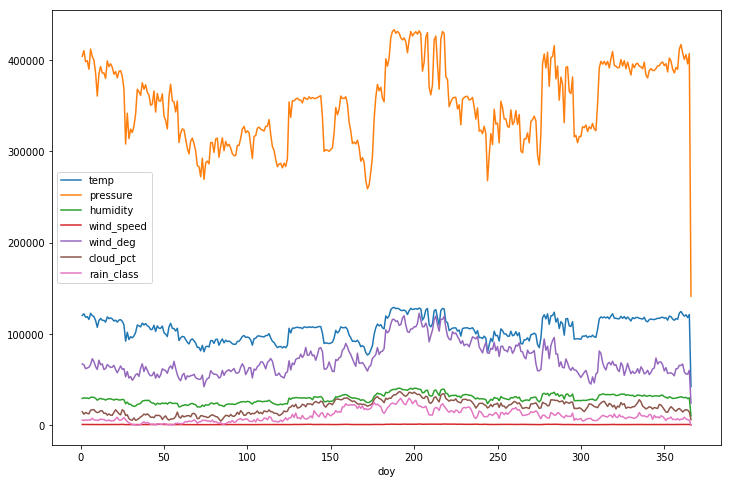

In [9]:
# Plot rain class to features
er_data[['doy','temp','pressure', 'humidity', 'wind_speed', 'wind_deg', 'cloud_pct', 'rain_class']
        ].groupby("doy", as_index=True).sum().plot(figsize=(12,8));

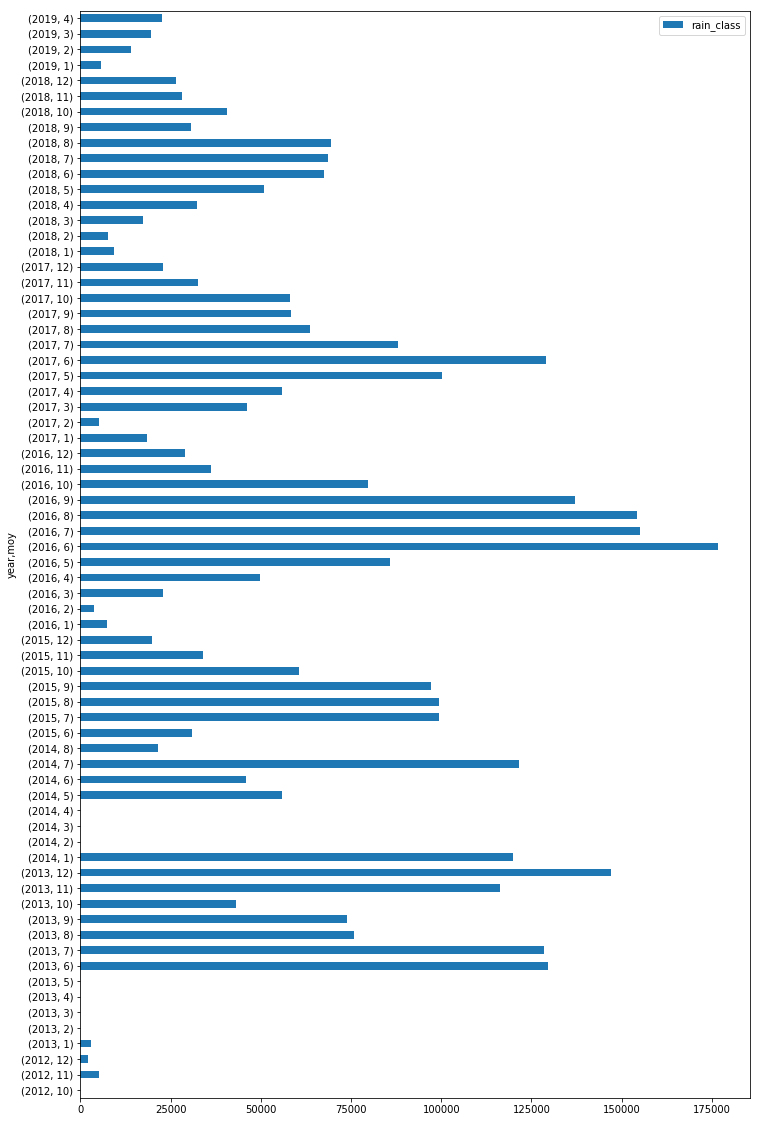

In [10]:
# Plot rain class to months
er_data[['year', 'moy', 'rain_class']
        ].groupby(["year", "moy"], as_index=True).sum().plot.barh(stacked=True,figsize=(12,20));

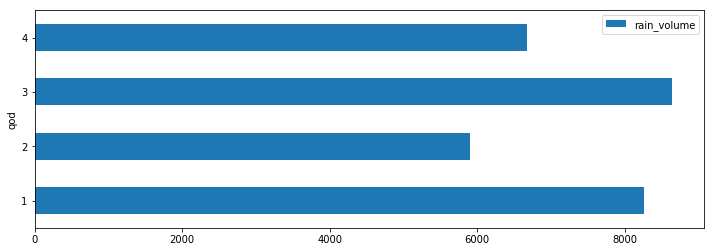

In [11]:
# Plot rain volume to quarter of day (24/4)
er_data[['qod', 'rain_volume']
        ].groupby("qod", as_index=True).sum().plot.barh(stacked=False,figsize=(12,4));

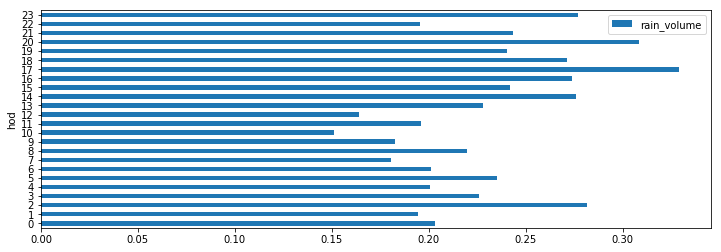

In [12]:
# Plot rain volume to hours of day
er_data[['hod', 'rain_volume']
        ].groupby("hod", as_index=True).mean().plot.barh(stacked=False,figsize=(12,4));

### 5.3 Observation On Eriched Data
- It can be observed that rainfall is propotionally variying with humidity, temperature (currently K, no difference with C), cloud percentage and pressure. 
- It is loosly dependent much on wind direction, but not much on wind speed.
- Rainfall generally peaks in months of June and July, and occassionally in August to December period.
- But is not much dependant on time of the day, though some reduction in 2nd quarter and slight increase in 3rd quarter of the 24hr day.
- Basic class (yes/no - 100/0) of rainfall is showing better trend with actual rainfall volumes than detailed class, so only using basic class

### 5.4 Verification Of Findings With Algorithms
Will use classification algorithms to verify the trend patterns observed,
- Decision Tree
- Linear Regression

But first, will transform the enriched dataset to a json format which is more suitable for classification algorithms. And will keep only selected features, with positive treand patterns to rainfall. 

In [13]:
# Variables
er_data_sel_train = []
er_data_sel_test = []

# Process enriched csv
with open(tmp_store + "hist_bulk_er.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        er_data_sel_row = []
        er_data_sel_row.append("{\"id\":")
        er_data_sel_row.append(row["id"])
        er_data_sel_row.append(",\"features\":[")
        er_data_sel_row.append(row["city_id"])
        er_data_sel_row.append(",")
        er_data_sel_row.append(row["humidity"])
        er_data_sel_row.append(",")
        er_data_sel_row.append(row["temp"])
        #er_data_sel_row.append(",")
        #er_data_sel_row.append(row["cloud_pct"])
        er_data_sel_row.append(",")
        er_data_sel_row.append(str(int(row["woy"])))
        #er_data_sel_row.append(",")
        #er_data_sel_row.append(str(int(row["qod"])))
        er_data_sel_row.append(",")
        er_data_sel_row.append(row["pressure"])
        er_data_sel_row.append("],\"classification\":")
        er_data_sel_row.append(row["rain_class"])
        er_data_sel_row.append(",\"value\":")
        er_data_sel_row.append(row["rain_volume"])
        er_data_sel_row.append("}")
        
        # Data from Apr-2018 as test data
        if int(row["day_num"]) <= 3012: 
            er_data_sel_train.append(''.join(er_data_sel_row))
        else:
            er_data_sel_test.append(''.join(er_data_sel_row))

# Train json file
with open(tmp_store + "hist_bulk_er_sel_train.json", 'w') as json_file:
    json_file.write("[" + ','.join(er_data_sel_train) + "]")

# Test json file
with open(tmp_store + "hist_bulk_er_sel_test.json", 'w') as json_file:
    json_file.write("[" + ','.join(er_data_sel_test) + "]")

In [14]:
# Get training and test data
with open(tmp_store + "hist_bulk_er_sel_train.json", 'r') as json_file:
    er_data_train = json.load(json_file)
    
with open(tmp_store + "hist_bulk_er_sel_test.json", 'r') as json_file:
    er_data_test = json.load(json_file)

## Prediction & Testing Functions ##
# Json data getters
def getId(data):
    return data['id']

def getFeatures(data):
    return data['features']

def getClassification(data):
    return data['classification']

def getValue(data):
    return data['value']

#Prediction function
def exePredict(algorithm, type, data_train, data_test):
    # Train data lists
    train_id = list(map(getId, data_train))
    train_feature = list(map(getFeatures, data_train))
    if type == 'classification':
        train_result = list(map(getClassification, data_train))
    elif type == 'regression':
        train_result = list(map(getValue, data_train))
    
    # Test data lists
    test_id = list(map(getId, data_test))
    test_feature = list(map(getFeatures, data_test))
    if type == 'classification':
        test_result = list(map(getClassification, data_test))
    elif type == 'regression':
        test_result = list(map(getValue, data_test))

    # Scaling features
    scale=MinMaxScaler(feature_range=(0,1))

    # Prediction
    fit = algorithm.fit(scale.fit_transform(train_feature), train_result)
    pred_result = fit.predict(scale.transform(test_feature))
    
    # Return result list
    return [list(i) for i in zip(test_id, test_result, pred_result)]

#### Decision Tree
Decision Tree classifier on rainfall class for every hour hour, for three locations in Kerala, India, over period of more than 6 years.


Mean Absolute Error
13.19

Accuracy Score
0.87

Confusion Matrix
[[18905  1879]
 [ 1491  3281]]


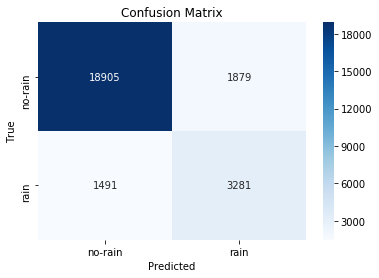

In [15]:
# Run Decision Tree classifier algorithm based prediction and test
result = exePredict(tree.DecisionTreeClassifier(), 'classification', er_data_train, er_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nAccuracy Score")
print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_predict))))
print("\nConfusion Matrix")
print (confusion_matrix(result_actual, result_predict))

# Plot Confusion Matrix
cm = plt.subplot()
sns.heatmap(confusion_matrix(result_actual, result_predict), annot=True, ax = cm, cmap='Blues', fmt='g'); 
cm.set_xlabel('Predicted');
cm.set_ylabel('True'); 
cm.set_title('Confusion Matrix'); 
cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
cm.yaxis.set_ticklabels(['no-rain', 'rain']);

#### Linear Regression
Linear Regression on rainfall volumes per hour, for three locations in Kerala, India, over period of more than 6 years.


Mean Absolute Error
0.26

Mean Squared Error
0.13


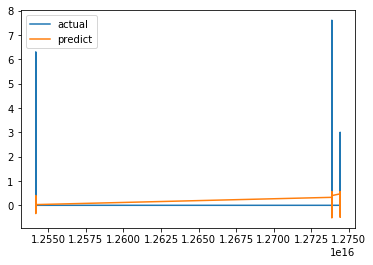

In [16]:
# Run Linear Regression algorithm based prediction and test
result = exePredict(linear_model.LinearRegression(), 'regression', er_data_train, er_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nMean Squared Error")
print ("{0:.2f}".format(Decimal(mean_squared_error(result_actual, result_predict))))

# Plot graph compare
plt.plot(result_id, result_actual, label = 'actual')
plt.plot(result_id, result_predict, label = 'predict')
plt.legend()
plt.show()

Removing Cloud Percentage, as it is found to be not positively influencing the rainfall. And infact is found to be slightly falsly influencing rain factor.

### 5.5 Adding Time Displaced Features
Assuming rainfall conditions have considerable dependancy on relatable time-displaced (previous day, previous week, same day last year) weather features, will add the weather features from these relative timelines.

In [17]:
# Add city-day_num-hr id to main (cdh_id)
er_main_file = csv.writer(open(tmp_store + "hist_bulk_er_main.csv", "w+", newline=''))

# Write CSV Header
er_main_file.writerow(["city_id", "city", "temp", "temp_min", "temp_max", "pressure","humidity",
                    "wind_speed","wind_deg","rain_1h","rain_3h","cloud_pct","weather_id","weather_main",
                    "weather_description","weather_icon","dt","dt_iso",                   
                   "dt_ind", "year", "moy", "woy", "doy", "dom", "qod", "hod", 
                   "mod", "day_num", "rain_volume", "rain_class", "id", "cdh_id"])

with open(tmp_store + "hist_bulk_er.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        er_main_row = list(row.values())
        # Generate cdh_id
        er_main_row.append(row["city_id"] + row['day_num'] + row['hod'])
                
        # Append to td file                           
        er_main_file.writerow(er_main_row)

        
# Add city-day_num-hr id to 1w
er_1w_file = csv.writer(open(tmp_store + "hist_bulk_er_1w.csv", "w+", newline=''))

# Write CSV Header
er_1w_file.writerow(["city_id", "city", "temp", "temp_min", "temp_max", "pressure","humidity",
                    "wind_speed","wind_deg","rain_1h","rain_3h","cloud_pct","weather_id","weather_main",
                    "weather_description","weather_icon","dt","dt_iso",                   
                   "dt_ind", "year", "moy", "woy", "doy", "dom", "qod", "hod", 
                   "mod", "day_num", "rain_volume", "rain_class", "id", "cdh_id"])

with open(tmp_store + "hist_bulk_er.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        er_1w_row = list(row.values())
        er_1w_row.append(row["city_id"] + str((int(row['day_num'])+7)) + row['hod'])
                
        # Append to td file                           
        er_1w_file.writerow(er_1w_row)
        
        
# Add city-day_num-hr id to 1y
er_1y_file = csv.writer(open(tmp_store + "hist_bulk_er_1y.csv", "w+", newline=''))

# Write CSV Header
er_1y_file.writerow(["city_id", "city", "temp", "temp_min", "temp_max", "pressure","humidity",
                    "wind_speed","wind_deg","rain_1h","rain_3h","cloud_pct","weather_id","weather_main",
                    "weather_description","weather_icon","dt","dt_iso",                   
                   "dt_ind", "year", "moy", "woy", "doy", "dom", "qod", "hod", 
                   "mod", "day_num", "rain_volume", "rain_class", "id", "cdh_id"])

with open(tmp_store + "hist_bulk_er.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        er_1y_row = list(row.values())
        er_1y_row.append(row["city_id"] + str((int(row['day_num'])+365)) + row['hod'])
                
        # Append to td file                           
        er_1y_file.writerow(er_1y_row)

In [18]:
# Time-Displace features added file with new features
er_data_main = pandas.read_csv(tmp_store + "hist_bulk_er_main.csv",sep=",")
er_data_1w = pandas.read_csv(tmp_store + "hist_bulk_er_1w.csv",sep=",")
er_data_1y = pandas.read_csv(tmp_store + "hist_bulk_er_1y.csv",sep=",")

td_data_1w_1y = pandas.merge(er_data_1w, er_data_1y, left_on='cdh_id',right_on='cdh_id',how='inner',suffixes=('_1w','_1y'))
td_data = pandas.merge(td_data_1w_1y, er_data_main, left_on='cdh_id',right_on='cdh_id',how='inner',suffixes=('',''))

# Write time-displaced data file (already enriched earlier)
td_data.to_csv(tmp_store + "hist_bulk_td.csv",sep=",")

### 5.6 Analyze Time Displaced Data
Analyze the modified data with time displaced features.

The fringe/outlier conditions with missing time displaced values, mainly due to unavaialblity of historic data, is removed directly with inner join of time displaced dataframes.

In [19]:
# Check sample data
td_data.head()

,city_id_1w,city_1w,temp_1w,temp_min_1w,temp_max_1w,pressure_1w,humidity_1w,wind_speed_1w,wind_deg_1w,rain_1h_1w,...,woy,doy,dom,qod,hod,mod,day_num,rain_volume,rain_class,id
0,1254163,trv,304.15,304.15,304.15,1011,70,3,260,NaN,...,39,276,3,2,12,30,1372,0.2,100,12541632013100312
1,1254163,trv,303.15,303.15,303.15,1009,74,3,280,NaN,...,39,276,3,3,15,30,1372,0.0,0,12541632013100315
2,1254163,trv,303.15,303.15,303.15,1010,74,2,280,NaN,...,39,276,3,3,17,30,1372,0.0,0,12541632013100317
3,1254163,trv,299.15,299.15,299.15,1011,88,1,320,NaN,...,39,276,3,4,23,30,1372,0.0,0,12541632013100323
4,1254163,trv,299.15,299.15,299.15,1011,88,1,290,NaN,...,39,277,4,1,0,30,1373,0.0,0,12541632013100400


#### 1 Year Displaced Feature Influence Analysis

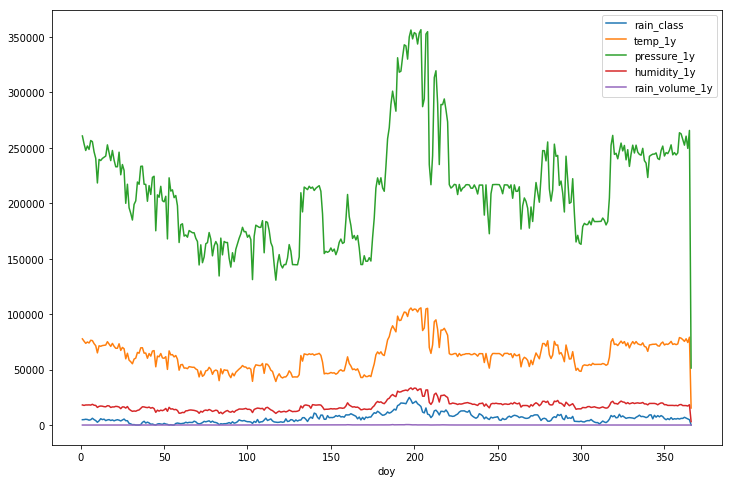

In [20]:
# Plot 1 year time displaced fetures
td_data[['doy', 'rain_class','temp_1y','pressure_1y', 'humidity_1y', 'rain_volume_1y']
        ].groupby("doy", as_index=True).sum().plot(figsize=(12,8));

#### 1 Week Displaced Feature Influence Analysis

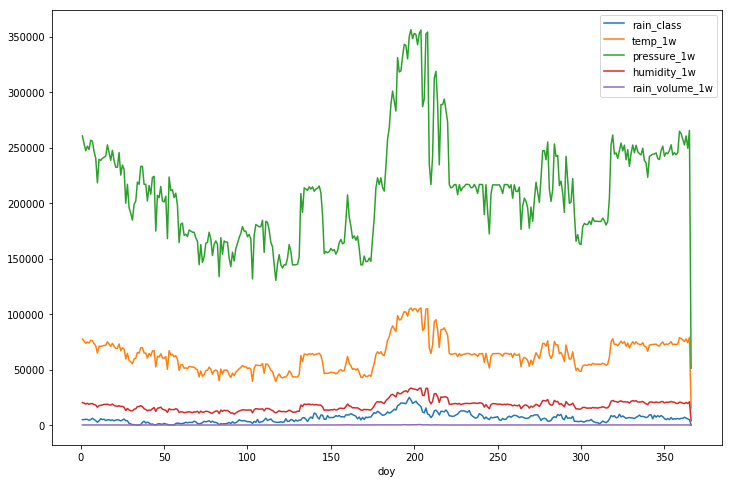

In [21]:
# Plot 1 week time displaced fetures
td_data[['doy', 'rain_class','temp_1w','pressure_1w', 'humidity_1w', 'rain_volume_1w']
        ].groupby("doy", as_index=True).sum().plot(figsize=(12,8));

### 5.7 Observation On Features
- It can be observed that rainfall is propotionally variying with humidity, temperature and pressure conditions, and can be used as prediction features.
- Cloud Percentage showns almost no correlation with rainfall
- Time factor has influence on rainfall, of which Week of Year has relatively better influence. If a time feature is selected, other additional time features (Month of Year, Day of Year, Quarter of Day, Hour of Day etc) does not have much additional influnce.
- The rain condition for a given time is showing posititvely dependent trend with temperature, humidity, pressure and rain volume conditions from 1 year and 1 week before. 
- Rainfall condition for a given time can be derived from 1 Year and/or 1 Week displaced features (above three and rainfall volume) from historic data.

## 6. Algorithm Selection & Modelling
Will use following algorithms considered to train, test and develop the final prediction model,
- Decision Tree
- Nearest Neighbors
- Gaussian Naive Bayes 
- Stochastic Gradient Descent
- Support Vector Machine (SVM)
- Linear Regression
- Support Vector Regression (SVR)

Support Vector methods are comparitively time inefficient and also is not showing any significant prediction accuracy over other methods, so botm SVM & SRV are not included in scope for modelling.

The features currently in consideration are,
- Location (current)
- Week of Year (current)
- Humidity (time displaced - 1Y, 1W)
- Temperature (time displaced - 1Y, 1W)
- Pressure (time displaced - 1Y, 1W)
- Rain Volume (time displaced - 1Y, 1W)

Will transform the the time displaced dataset to a json format which is more suitable for classification algorithms.

In [22]:
# Variables
td_data_sel_train = []
td_data_sel_test = []

# Process time-displaced csv
with open(tmp_store + "hist_bulk_td.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        td_data_sel_row = []
        td_data_sel_row.append("{\"id\":")
        td_data_sel_row.append(row["id"])
        td_data_sel_row.append(",\"features\":[")
        td_data_sel_row.append(row["city_id"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(str(int(row["woy"])))
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["humidity_1y"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["temp_1y"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["pressure_1y"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["rain_volume_1y"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["humidity_1w"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["temp_1w"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["pressure_1w"])
        td_data_sel_row.append(",")
        td_data_sel_row.append(row["rain_volume_1w"])
        td_data_sel_row.append("],\"classification\":")
        td_data_sel_row.append(row["rain_class"])
        td_data_sel_row.append(",\"value\":")
        td_data_sel_row.append(row["rain_volume"])
        td_data_sel_row.append("}")
        
        # Data from Apr-2018 as test data
        if int(row["day_num"]) <= 3012: 
            td_data_sel_train.append(''.join(td_data_sel_row))
        else:
            td_data_sel_test.append(''.join(td_data_sel_row))

# Train json file
with open(tmp_store + "hist_bulk_td_sel_train.json", 'w') as json_file:
    json_file.write("[" + ','.join(td_data_sel_train) + "]")

# Test json file
with open(tmp_store + "hist_bulk_td_sel_test.json", 'w') as json_file:
    json_file.write("[" + ','.join(td_data_sel_test) + "]")
    
# Get training and test data
with open(tmp_store + "hist_bulk_td_sel_train.json", 'r') as json_file:
    td_data_train = json.load(json_file)
    
with open(tmp_store + "hist_bulk_td_sel_test.json", 'r') as json_file:
    td_data_test = json.load(json_file)

### 6.1 Decision Tree




Mean Absolute Error
19.56

Accuracy Score
0.80

Confusion Matrix
[[17361  3320]
 [ 1653  3085]]


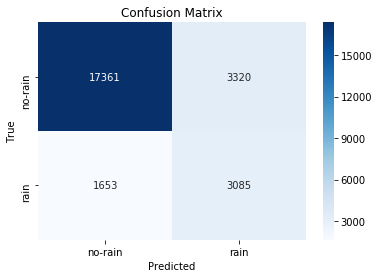

In [23]:
# Run Decision Tree classifier algorithm based prediction and test
result = exePredict(tree.DecisionTreeClassifier(), 'classification', td_data_train, td_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nAccuracy Score")
print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_predict))))
print("\nConfusion Matrix")
print (confusion_matrix(result_actual, result_predict))

# Plot Confusion Matrix
cm = plt.subplot()
sns.heatmap(confusion_matrix(result_actual, result_predict), annot=True, ax = cm, cmap='Blues', fmt='g'); 
cm.set_xlabel('Predicted');
cm.set_ylabel('True'); 
cm.set_title('Confusion Matrix'); 
cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
cm.yaxis.set_ticklabels(['no-rain', 'rain']);

### 6.2 Gaussian Naive Bayes


Mean Absolute Error
23.55

Accuracy Score
0.76

Confusion Matrix
[[15789  4892]
 [ 1095  3643]]


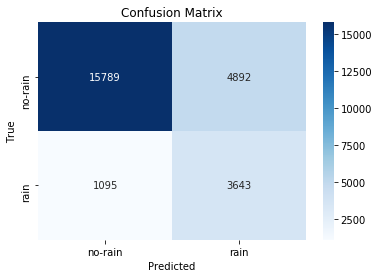

In [24]:
# Run Naive Bayes classifier algorithm based prediction and test
result = exePredict(GaussianNB(priors=None), 'classification', td_data_train, td_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nAccuracy Score")
print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_predict))))
print("\nConfusion Matrix")
print (confusion_matrix(result_actual, result_predict))

# Plot Confusion Matrix
cm = plt.subplot()
sns.heatmap(confusion_matrix(result_actual, result_predict), annot=True, ax = cm, cmap='Blues', fmt='g'); 
cm.set_xlabel('Predicted');
cm.set_ylabel('True'); 
cm.set_title('Confusion Matrix'); 
cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
cm.yaxis.set_ticklabels(['no-rain', 'rain']);

### 6.3 K Nearest Neighbors


Mean Absolute Error
19.37

Accuracy Score
0.81

Confusion Matrix
[[17425  3256]
 [ 1667  3071]]


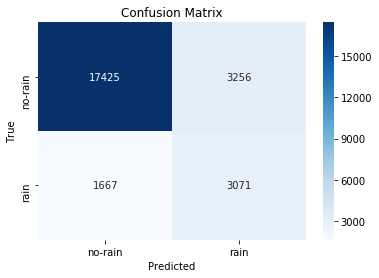

In [25]:
# Run K Nearest Neighbors classifier algorithm based prediction and test
result = exePredict(KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='auto'), 'classification', td_data_train, td_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nAccuracy Score")
print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_predict))))
print("\nConfusion Matrix")
print (confusion_matrix(result_actual, result_predict))

# Plot Confusion Matrix
cm = plt.subplot()
sns.heatmap(confusion_matrix(result_actual, result_predict), annot=True, ax = cm, cmap='Blues', fmt='g'); 
cm.set_xlabel('Predicted');
cm.set_ylabel('True'); 
cm.set_title('Confusion Matrix'); 
cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
cm.yaxis.set_ticklabels(['no-rain', 'rain']);

### 6.4 Stochastic Gradient Descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.




Mean Absolute Error
25.34

Accuracy Score
0.75

Confusion Matrix
[[15313  5368]
 [ 1072  3666]]


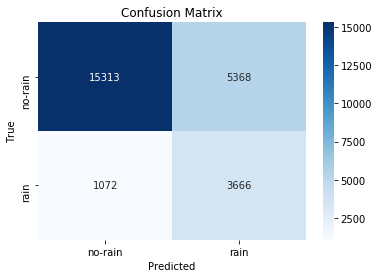

In [26]:
# Run Stochastic Gradient Descent algorithm based prediction and test
result = exePredict(SGDClassifier(loss="hinge", penalty="l2"), 'classification', td_data_train, td_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nAccuracy Score")
print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_predict))))
print("\nConfusion Matrix")
print (confusion_matrix(result_actual, result_predict))

# Plot Confusion Matrix
cm = plt.subplot()
sns.heatmap(confusion_matrix(result_actual, result_predict), annot=True, ax = cm, cmap='Blues', fmt='g'); 
cm.set_xlabel('Predicted');
cm.set_ylabel('True'); 
cm.set_title('Confusion Matrix'); 
cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
cm.yaxis.set_ticklabels(['no-rain', 'rain']);

### 6.6 Linear Regression

In [27]:
# Run Linear Regression based prediction and test
result = exePredict(linear_model.LinearRegression(), 'regression', td_data_train, td_data_test)

# Result values
result_id = [x[0] for x in result]
result_actual = [x[1] for x in result]
result_predict = [x[2] for x in result]

# Check error
print("\nMean Absolute Error")
print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_predict))))
print("\nMean Squared Error")
print ("{0:.2f}".format(Decimal(mean_squared_error(result_actual, result_predict))))


Mean Absolute Error
0.22

Mean Squared Error
0.14


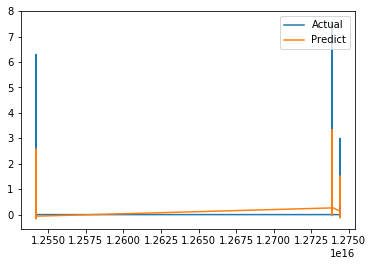

In [28]:
# Plot graph compare
plt.plot(result_id, result_actual, label='Actual')
plt.plot(result_id, result_predict, label='Predict')
plt.legend(loc='upper right')
plt.show()

### 6.5 Observation
- 1 Year and 1 Week displaced features together gives better results.
- Classification algorithms are able to predict with reasonable accuracy (near 0.8) for rain class
- Among classifiers, Gaussian Naive Bayes is performing best for the given condition for weather in Kerala, India.
- Linear Regression method is performing well with very low mean error for rain volume preidtion

## 7. Rainfall Forecast
- Will use Gaussian Naive Bayes for forecasting rainfall class for next 7 days
- WIll use Linear Regression for forecasting rainfall volume for next 7 day

This module has capability to forecast rainfall class (possibility) and volume for next 7 days at an hourly frequency. And has two options, cpntrolled by 'ACTION_TYPE' parameter
    - to forecast and test accuracy on already avaiable data
    - to forecast for dates without data
    
The 'CURRENT_DATE' parameter can be used to control the date value for assumed day from which the forecast needs to be done.

In [29]:
# Input Parameters
CURRENT_DATE = '2018-12-01' #YYYY-MM-DD format
ACTION_TYPE = 'forecast' #'forecast', 'forecast-test'

# Variables
data_train = []
data_forecast = []
city_id = ['1254163', '1273874', '1274428']

# Forecast max date --> current date + 7 days
dt_current = datetime.datetime.strptime(CURRENT_DATE + ' 23:59:59', '%Y-%m-%d %H:%M:%S')
dt_forecast_max = dt_current + datetime.timedelta(days=7)

# Prepare forecast dataset
if ACTION_TYPE == 'forecast-test':
    er_data_main_forecast = er_data_main[er_data_main["dt_ind"] <= str(dt_forecast_max)]
elif ACTION_TYPE == 'forecast':
    # Remove data greater than CURRENT_DATE - to simulate actual forecasting scenario
    er_data_main_forecast_tmp = er_data_main[er_data_main["dt_ind"] <= str(dt_current)]

    # Add hourly place holder for 7-Day forecasting period
    for city in range(0, len(city_id)): 
        for day in range(0, 7): 
            dt_forecast = dt_current + datetime.timedelta(days=(day+1))
            for hour in range(0, 24):
                # Add instance id
                id_forcast = (city_id[city] + dt_forecast.strftime("%Y") + dt_forecast.strftime("%m") 
                              + dt_forecast.strftime("%d") + "{:02d}".format(hour))
                # Add cdh_id
                cdh_id_forcast = city_id[city] + str(getDayNum(dt_forecast)) + "{:02d}".format(hour)
                # Append to main forecast data set
                er_data_main_forecast_tmp = er_data_main_forecast_tmp.append({'city_id':''+ city_id[city] +'', 
                                                                    'dt_ind':''+ str(dt_forecast) +'',
                                                                    'woy':'' + dt_forecast.strftime("%U") + '', 
                                                                    'rain_volume':'0',
                                                                    'rain_class':'0',
                                                                    'id':''+ id_forcast +'', 
                                                                    'cdh_id':''+ cdh_id_forcast +''}, 
                                                                    ignore_index=True)              

    # Write and Read forecast ready main dataset 
    er_data_main_forecast_tmp.to_csv(tmp_store + "hist_bulk_er_main_forecast.csv",sep=",")
    er_data_main_forecast = pandas.read_csv(tmp_store + "hist_bulk_er_main_forecast.csv",sep=",")          
    #er_data_main_forecast.sort_values('cdh_id', inplace=True)
    
# Get final forecast ready dataset
td_data_forecast = pandas.merge(td_data_1w_1y, er_data_main_forecast, left_on='cdh_id',
                             right_on='cdh_id',sort=True, how='inner',suffixes=('',''))

# Write forecast ready dataset file 
td_data_forecast.to_csv(tmp_store + "hist_bulk_td_forecast.csv",sep=",")

#### Latest Data From Main Dataset
The latest data in the main dataset (from historic weather data) for,
- forecast & test, will be till 7 days post assumed current date (for comparison accuracy testing)
- full-fledged forecasting, will be only till the assumed current date

Note: Only displaying selected fields (primary influencing factors/description/id).

In [30]:
# Print main dataset lastest data
er_data_main_forecast.sort_values(['day_num', 'hod', 'city_id'], ascending=False)[["city_id", "city", "temp", "pressure",
                    "humidity", "weather_main", "dt_ind", "woy", "day_num", "rain_volume", "rain_class", "id", "cdh_id"]].head()

,city_id,city,temp,pressure,humidity,weather_main,dt_ind,woy,day_num,rain_volume,rain_class,id,cdh_id
120526,1274428,cgr,295.82,987.0,89.0,Rain,2018-12-01 23:30:00+05:30,47,3257.0,0.3,100,12744282018120123,1274428325723
80602,1273874,koc,299.15,1010.0,94.0,Haze,2018-12-01 23:30:00+05:30,47,3257.0,0.0,0,12738742018120123,1273874325723
40782,1254163,trv,301.15,1009.0,78.0,Haze,2018-12-01 23:30:00+05:30,47,3257.0,0.0,0,12541632018120123,1254163325723
120525,1274428,cgr,295.82,987.0,89.0,Rain,2018-12-01 22:30:00+05:30,47,3257.0,0.3,100,12744282018120122,1274428325722
80601,1273874,koc,300.15,1010.0,88.0,Haze,2018-12-01 22:30:00+05:30,47,3257.0,0.0,0,12738742018120122,1273874325722


In [31]:
# Process time-displaced csv
with open(tmp_store + "hist_bulk_td_forecast.csv", mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        data_row = []
        data_row.append("{\"id\":")
        data_row.append(row["id"])
        data_row.append(",\"features\":[")
        data_row.append(row["city_id"])
        data_row.append(",")
        data_row.append(str(int(row["woy"])))
        data_row.append(",")
        data_row.append(row["humidity_1y"])
        data_row.append(",")
        data_row.append(row["temp_1y"])
        data_row.append(",")
        data_row.append(row["pressure_1y"])
        data_row.append(",")
        data_row.append(row["rain_volume_1y"])
        data_row.append(",")
        data_row.append(row["humidity_1w"])
        data_row.append(",")
        data_row.append(row["temp_1w"])
        data_row.append(",")
        data_row.append(row["pressure_1w"])
        data_row.append(",")
        data_row.append(row["rain_volume_1w"])
        data_row.append("],\"classification\":")
        data_row.append(row["rain_class"])
        data_row.append(",\"value\":")
        data_row.append(row["rain_volume"])
        data_row.append("}")   
        
        # DateTime for this occurance
        datetime_this = datetime.datetime.strptime(row["dt_ind"][:18], '%Y-%m-%d %H:%M:%S')
        
        # Split train and forecast (test) datasets
        if datetime_this <= dt_current: 
            data_train.append(''.join(data_row))
        else:
            data_forecast.append(''.join(data_row))

# Train json file
with open(tmp_store + "data_train.json", 'w') as json_file:
    json_file.write("[" + ','.join(data_train) + "]")

# Test json file
with open(tmp_store + "data_forecast.json", 'w') as json_file:
    json_file.write("[" + ','.join(data_forecast) + "]")
    
# Get training and test data
with open(tmp_store + "data_train.json", 'r') as json_file:
    td_data_train = json.load(json_file)
    
with open(tmp_store + "data_forecast.json", 'r') as json_file:
    td_data_forecast = json.load(json_file)

### 7.1 Rainfall Class Prediction With Naive Bayes 

In [32]:
# Run Naive Bayes classifier algorithm based prediction and test
result = exePredict(GaussianNB(priors=None), 'classification', td_data_train, td_data_forecast)

# Result values
result_id = [x[0] for x in result]
result_city = [int(str(x[0])[:7]) for x in result]
result_time = [(str(x[0])[7:11])+"-"+(str(x[0])[11:13])+"-"+(str(x[0])[13:15])+" "+(str(x[0])[15:17])+":00:00" for x in result]
result_actual = [x[1] for x in result]
result_forecast = [x[2] for x in result]

# Prediction accuracy check only if 'forecast-test'
if ACTION_TYPE == 'forecast-test':
    # Check error
    print("\nMean Absolute Error")
    print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_forecast))))
    print("\nAccuracy Score")
    print ("{0:.2f}".format(Decimal(accuracy_score(result_actual, result_forecast))))
    print("\nConfusion Matrix")
    print (confusion_matrix(result_actual, result_forecast))

    # Plot Confusion Matrix
    cm = plt.subplot()
    sns.heatmap(confusion_matrix(result_actual, result_forecast), annot=True, ax = cm, cmap='Blues', fmt='g'); 
    cm.set_xlabel('Forecast');
    cm.set_ylabel('True'); 
    cm.set_title('Confusion Matrix'); 
    cm.xaxis.set_ticklabels(['no-rain', 'rain']); 
    cm.yaxis.set_ticklabels(['no-rain', 'rain']);    

In [33]:
# Forecast result
result_mod = [list(i) for i in zip(result_city, result_time, result_forecast)]

# Forecast file
with open(tmp_store + "forecast_rain_class.csv", 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['city', 'time', 'rain'])
    writer.writerows(result_mod)

# Get forecast data
forecast_data = pandas.read_csv(tmp_store + "forecast_rain_class.csv",sep=",")
#predict_data.head()

# Pivot forecast data
forecast_data_pivot = pandas.pivot_table(forecast_data, values='rain', index=['time'], columns=['city'], aggfunc=numpy.sum)

# Write forecast ready dataset file 
forecast_data_pivot.to_csv(tmp_store + "forecast_rain_class_pivot.csv",sep=",")

# Head predict_data_pivot
forecast_data_pivot.head()

city,1254163,1273874,1274428
time,,,
2018-12-02 00:00:00,0.0,0.0,100.0
2018-12-02 01:00:00,0.0,0.0,100.0
2018-12-02 02:00:00,0.0,0.0,100.0
2018-12-02 03:00:00,0.0,0.0,100.0
2018-12-02 04:00:00,0.0,0.0,100.0


In [34]:
# Get report data
forecast_data_pivot_report = pandas.read_csv(tmp_store + "forecast_rain_class_pivot.csv",sep=",")

# Init plot
ofl.init_notebook_mode(connected=True)

# Set plot data
data = [dict(
        type = 'scatter',
        name = 'Thiruvananthapuram',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1254163']),
        mode = 'markers'
    ),
    dict(
        type = 'scatter',
        name = 'Kochi',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1273874']),
        mode = 'markers'
    ),
       dict(
        type = 'scatter',
        name = 'Chengannur',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1274428']),
        mode = 'markers'
    )]

# Draw plot (sometime need import done with active internet connection)
ofl.iplot({'data': data}, validate=False)

### 7.2 Rainfall Volume Prediction With Linear Regression

In [35]:
# Run Linear Regression based prediction and test
result = exePredict(linear_model.LinearRegression(), 'regression', td_data_train, td_data_forecast)

# Result values
result_id = [x[0] for x in result]
result_city = [int(str(x[0])[:7]) for x in result]
result_time = [(str(x[0])[7:11])+"-"+(str(x[0])[11:13])+"-"+(str(x[0])[13:15])+" "+(str(x[0])[15:17])+":00:00" for x in result]
result_actual = [x[1] for x in result]
result_forecast = [x[2] for x in result]

# Prediction accuracy check only if 'forecast-test'
if ACTION_TYPE == 'forecast-test':
    # Check error
    print("\nMean Absolute Error")
    print ("{0:.2f}".format(Decimal(mean_absolute_error(result_actual, result_forecast))))
    print("\nMean Squared Error")
    print ("{0:.2f}".format(Decimal(mean_squared_error(result_actual, result_forecast))))

    # Plot graph compare
    plt.plot(result_id, result_actual, label='Actual')
    plt.plot(result_id, result_forecast, label='Forecast')
    plt.legend(loc='upper right')
    #plt.rcParams["figure.figsize"] = (15,5)
    #plt.ylim(-1, 1)
    plt.show()

In [36]:
# Forecast result
result_mod = [list(i) for i in zip(result_city, result_time, result_forecast)]

# Forecast file
with open(tmp_store + "forecast_rainfall_volume.csv", 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['city', 'time', 'rain'])
    writer.writerows(result_mod)

# Get predict data
forecast_data = pandas.read_csv(tmp_store + "forecast_rainfall_volume.csv",sep=",")
#predict_data.head()

# Pivot predict data
forecast_data_pivot = pandas.pivot_table(forecast_data, values='rain', index=['time'], columns=['city'], aggfunc=numpy.sum)

# Write forecast ready dataset file 
forecast_data_pivot.to_csv(tmp_store + "forecast_rainfall_volume_pivot.csv",sep=",")

# Head predict_data_pivot
forecast_data_pivot.head()

city,1254163,1273874,1274428
time,,,
2018-12-02 00:00:00,0.115103,0.324117,0.242480
2018-12-02 01:00:00,0.116609,0.336870,0.576095
2018-12-02 02:00:00,0.143688,0.341679,0.576095
2018-12-02 03:00:00,0.139933,0.343184,0.576095
2018-12-02 04:00:00,0.148497,0.364941,0.212579


In [37]:
# Get report data
forecast_data_pivot_report = pandas.read_csv(tmp_store + "forecast_rainfall_volume_pivot.csv",sep=",")

# Init plot
ofl.init_notebook_mode(connected=True)

# Set plot data
data = [dict(
        type = 'scatter',
        name = 'Thiruvananthapuram',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1254163']),
        mode = 'lines'
    ),
    dict(
        type = 'scatter',
        name = 'Kochi',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1273874']),
        mode = 'lines'
    ),
       dict(
        type = 'scatter',
        name = 'Chengannur',
        x = list(forecast_data_pivot_report['time']),
        y = list(forecast_data_pivot_report['1274428']),
        mode = 'lines'
    )]

# Draw plot
ofl.iplot({'data': data}, validate=False)

### 7.3 Observations On Forecast
- Rainfall Class forecast with Naive Bayes is showing fair accuracy ranging from 0.75 to 0.85 in most cases (mean absolute error near 20)
- Rainfall Volume forcast, based on Linear Regression, achieved even better results with mean absolute error less than 1
- Weather Forecasting is able to give high accuracy results in seasons with stable weather (summer/rainy season), but tends to be of lower accuracy in seasons with mixed weather
- Of the 3 locations selected, Chengannur generally shows highest trend for rainy weather, almost closely followed by Kochi and Thiruvananthapuram leans towards a less rainy dry weather.

## 8. Conclusion
We were able to forecast the rainfall conditions with fair degree of accuracy. But it is difficult to achieve very high accuracy in forecasting rainfall with machine learning, especially for longer periods of time, mainly due to high amount of fluctuations in weather conditions.

The developed models can be used for forecasting the rainfall conditions for immediate 1 week with at an hourly frequency with good amount of accuracy.


## 9. What Next
- Fine tune the models with data from more locations
- Improve feature engineering by introducing weightage
- Use neural networks for forecasting weather
- Develop models to forecast weather for a longer period of time, with more detailed results
